In [289]:
%%time
%matplotlib inline
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random
import xgboost as xgb
from sklearn.metrics import matthews_corrcoef

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from xgboost import XGBRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import matthews_corrcoef, roc_auc_score
from sklearn.grid_search import RandomizedSearchCV
from catboost import CatBoostClassifier,CatBoostRegressor

from rgf.sklearn import RGFClassifier,RGFRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder,LabelEncoder

from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.ensemble import ExtraTreesClassifier,ExtraTreesRegressor
from sklearn.feature_selection import VarianceThreshold

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score,mean_squared_error
from math import sqrt
from scipy import stats
from scipy.stats import norm, skew #for some statistics
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV

Wall time: 38 ms


In [282]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [321]:
%%time
os.chdir(r'C:\Users\royal\Downloads\analiticv')
train=pd.read_csv('train_NIR5Yl1.csv')
test=pd.read_csv('test_8i3B3FC.csv')

Wall time: 2.46 s


In [322]:
train.head()
test.head()

,ID,Tag,Reputation,Answers,Username,Views,Upvotes
0,52664,a,3942.0,2.0,155623,7855.0,42.0
1,327662,a,26046.0,12.0,21781,55801.0,1175.0
2,468453,c,1358.0,4.0,56177,8067.0,60.0
3,96996,a,264.0,3.0,168793,27064.0,9.0
4,131465,c,4271.0,4.0,112223,13986.0,83.0


,ID,Tag,Reputation,Answers,Username,Views
0,366953,a,5645.0,3.0,50652,33200.0
1,71864,c,24511.0,6.0,37685,2730.0
2,141692,i,927.0,1.0,135293,21167.0
3,316833,i,21.0,6.0,166998,18528.0
4,440445,i,4475.0,10.0,53504,57240.0


In [323]:
train.shape
test.shape
train.columns

(330045, 7)

(141448, 6)

Index(['ID', 'Tag', 'Reputation', 'Answers', 'Username', 'Views', 'Upvotes'], dtype='object')

In [324]:
len(train.ID)
train.Tag.unique()
len(train.Reputation.unique())
train.Answers.unique()
len(train.Username.unique())
len(train.Views.unique())
len(train.Upvotes.unique())

330045

array(['a', 'c', 'r', 'j', 'p', 's', 'h', 'o', 'i', 'x'], dtype=object)

16527

array([  2.,  12.,   4.,   3.,   1.,   7.,   8.,   0.,   5.,  13.,   9.,
        22.,  10.,   6.,  11.,  41.,  16.,  17.,  25.,  19.,  21.,  15.,
        20.,  14.,  18.,  30.,  34.,  37.,  33.,  24.,  26.,  28.,  29.,
        31.,  27.,  23.,  32.,  39.,  49.,  35.,  38.,  36.,  50.,  43.,
        47.,  61.,  51.,  57.,  40.,  54.,  46.,  62.,  48.,  60.,  53.,
        59.,  42.,  45.,  76.,  66.,  44.,  58.,  55.])

141802

82137

7239

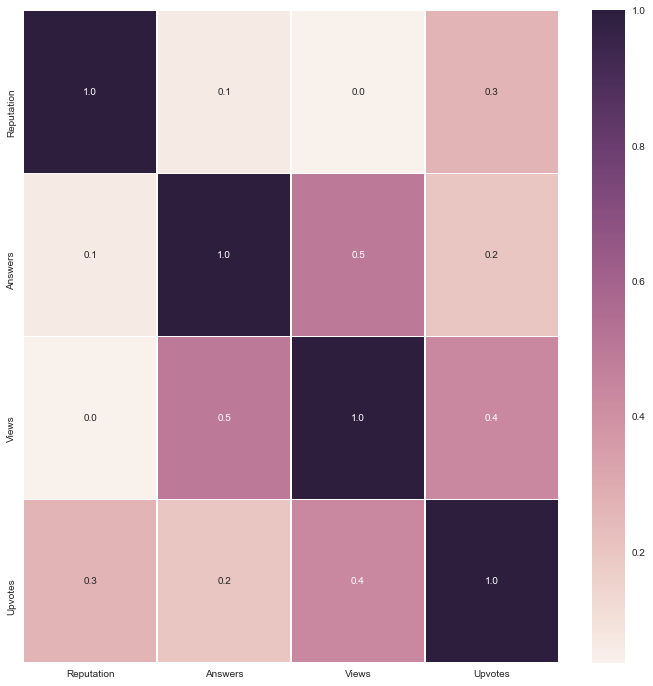

In [325]:
f,ax=plt.subplots(figsize=(12,12))
sns.heatmap(train[['Tag','Reputation','Answers','Views','Upvotes']].corr(),annot=True,linewidths=.5,fmt='.1f',ax=ax)

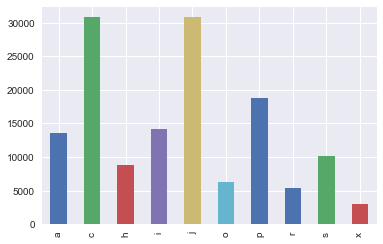

In [151]:
# train.Views.hist()
test['Tag'].value_counts().sort_index().head(20).plot.bar()

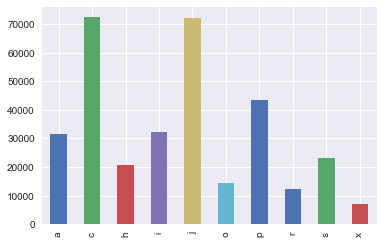

In [326]:

train['Tag'].value_counts().sort_index().head(20).plot.bar()
# test['Tag'].value_counts().sort_index().head(20).plot.bar()

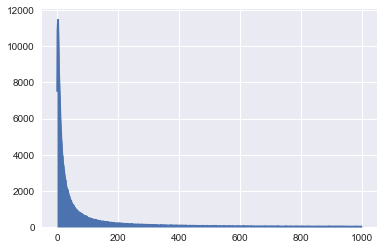

In [327]:
train['Upvotes'].value_counts().sort_index()[:1000].plot.area()

Text(0,0.5,'Upvotes')

Text(0.5,0,'Views')

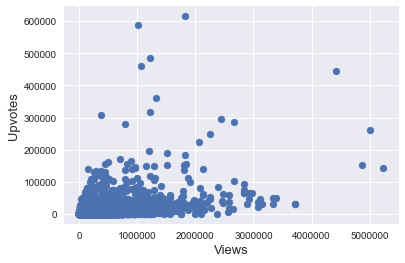

In [331]:
fig, ax = plt.subplots()
ax.scatter(x = train['Views'], y = train['Upvotes'])
plt.ylabel('Upvotes', fontsize=13)
plt.xlabel('Views', fontsize=13)
plt.show()

In [92]:
##outliers at 3000000 views have to remove that
# test[test.Views > 3000000]
train[train.Upvotes>210000]

,ID,Tag,Reputation,Answers,Username,Views,Upvotes
18636,300612,c,163511.0,20.0,58206,1331067.0,360073.0
33523,451519,j,280802.0,15.0,58312,786158.0,278728.0
37080,316311,j,518066.0,32.0,30884,1068171.0,460447.0
43972,213203,j,287981.0,21.0,32675,1225923.0,483995.0
55806,194475,h,90911.0,29.0,6697,4417626.0,445709.0
86457,160061,j,491244.0,39.0,88862,1815987.0,615278.0
132439,441845,j,48827.0,59.0,171666,5004985.0,261157.0
146919,92513,p,89433.0,14.0,13600,2662604.0,286529.0
164943,296722,a,518091.0,19.0,30884,380058.0,308308.0
175240,326345,j,99319.0,36.0,141466,2256833.0,248521.0


Text(0,0.5,'Upvotes')

Text(0.5,0,'Reputation')

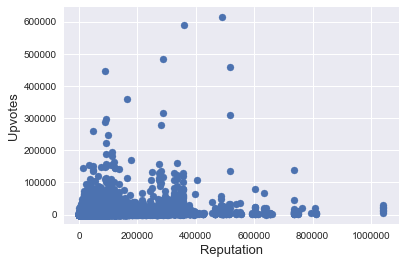

In [329]:
fig, ax = plt.subplots()
ax.scatter(x = train['Reputation'], y = train['Upvotes'])
plt.ylabel('Upvotes', fontsize=13)
plt.xlabel('Reputation', fontsize=13)
plt.show()

In [330]:
test[test.Reputation > 900000]

,ID,Tag,Reputation,Answers,Username,Views
88713,401171,s,1042428.0,9.0,46604,5563.0


Text(0,0.5,'Upvotes')

Text(0.5,0,'Answers')

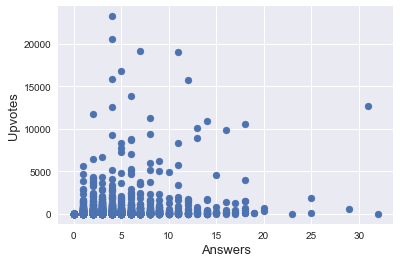

In [257]:
#ID	Tag	Reputation	Answers	Username	Views	Upvotes
#Tag - ['a', 'c', 'r', 'j', 'p', 's', 'h', 'o', 'i', 'x']
fig, ax = plt.subplots()
ax.scatter(x = train[train.Tag == 'x']['Answers'], y = train[train.Tag == 'x']['Upvotes'])
plt.ylabel('Upvotes', fontsize=13)
plt.xlabel('Answers', fontsize=13)
plt.show()

In [258]:
train[train.Tag == 'x'][train['Answers']>28]
test[test.Tag == 'x'][test['Answers']>28]

C:\Users\royal\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,ID,Tag,Reputation,Answers,Username,Views,Upvotes
49693,201149,x,7516.0,29.0,72591,125608.0,631.0
57838,415253,x,0.0,32.0,62142,335417.0,0.0
318000,442284,x,31787.0,31.0,89106,381724.0,12637.0


C:\Users\royal\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,ID,Tag,Reputation,Answers,Username,Views


In [144]:
#(330045, 7) original
#(330015, 7) after outlier remove
train.shape

(330023, 7)

In [285]:
#Deleting outliers
train = train.drop(train[(train['Views']>3100000) | (train['Reputation'] > 900000) | (train['Upvotes'] > 210000) | (train['Answers'] > 65)].index)

In [148]:
train.Tag.unique()
test.Tag.unique()
# train[train.Tag == 'a']

array(['a', 'c', 'r', 'j', 'p', 's', 'h', 'o', 'i', 'x'], dtype=object)

array(['a', 'c', 'i', 'x', 's', 'p', 'o', 'j', 'h', 'r'], dtype=object)

C:\Users\royal\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "



 mu = 7920.93 and sigma = 27910.63



Text(0,0.5,'Frequency')

Text(0.5,1,'Upvotes distribution')

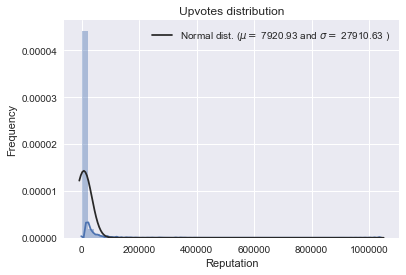

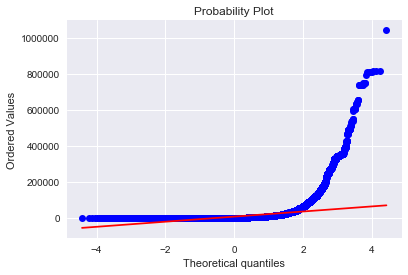

In [87]:
sns.distplot(test['Reputation'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(test['Reputation'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Upvotes distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(test['Reputation'], plot=plt)
plt.show()

In [286]:
train["Upvotes"] = np.log1p(train["Upvotes"])
train["Reputation"] = np.log1p(train["Reputation"])
train["Views"] = np.log1p(train["Views"])
train["Answers"] = np.log1p(train["Answers"])

test["Reputation"] = np.log1p(test["Reputation"])
test["Views"] = np.log1p(test["Views"])
test["Answers"] = np.log1p(test["Answers"])


In [277]:
train.Reputation.max()
pca = PCA(n_components=8)

X_scaled=pca.fit_transform(train_features)
test_X_scaled = pca.transform(test_features)

13.608947536797285

In [287]:
#Drop the irrelevant features from the test set
train_labels = np.array(train['Upvotes'])
train_features = train.drop(['Upvotes','ID','Username'], axis=1)
train_features = pd.get_dummies(train_features)
train_features = train_features.fillna(0)
train_features.head(5)

#Drop the irrelevant features from the test set
ID_test = test['ID']
test_features = test.drop(['ID','Username'], axis=1)
test_features = pd.get_dummies(test_features)
test_features.head(5)

,Reputation,Answers,Views,Tag_a,Tag_c,Tag_h,Tag_i,Tag_j,Tag_o,Tag_p,Tag_r,Tag_s,Tag_x
0,8.279697,1.098612,8.969033,1,0,0,0,0,0,0,0,0,0
1,10.167658,2.564949,10.929565,1,0,0,0,0,0,0,0,0,0
2,7.214504,1.609438,8.995661,0,1,0,0,0,0,0,0,0,0
3,5.579730,1.386294,10.205997,1,0,0,0,0,0,0,0,0,0
4,8.359837,1.609438,9.545884,0,1,0,0,0,0,0,0,0,0


,Reputation,Answers,Views,Tag_a,Tag_c,Tag_h,Tag_i,Tag_j,Tag_o,Tag_p,Tag_r,Tag_s,Tag_x
0,8.638703,1.386294,10.410335,1,0,0,0,0,0,0,0,0,0
1,10.106918,1.945910,7.912423,0,1,0,0,0,0,0,0,0,0
2,6.833032,0.693147,9.960246,0,0,0,1,0,0,0,0,0,0
3,3.091042,1.945910,9.827092,0,0,0,1,0,0,0,0,0,0
4,8.406485,2.397895,10.955026,0,0,0,1,0,0,0,0,0,0


In [17]:
test.isnull().sum().sum()

0

In [50]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

train['Tag'] = le.fit_transform(train['Tag'])
test['Tag'] = le.fit_transform(test['Tag'])

In [52]:
Y1=train['Upvotes']
train1=train.drop(['ID','Upvotes','Username'],axis=1)
train1=train1.values
Y=Y1.values

test_id=test['ID']
test1 = test.drop(['ID','Username'],axis=1)
test1=test1.values

In [129]:
train1.shape
test1.shape
train_features.shape
test_features.shape

(330015, 4)

(141448, 4)

(330015, 13)

(141448, 13)

In [54]:
#scale training and testing data.
scaler = StandardScaler()
scaler.fit(train1)
train2 = scaler.transform(train1)
test2 = scaler.transform(test1)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [55]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train1)
train_2=scaler.transform(train1)
test_2=scaler.transform(test1)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [ ]:
#make 2 way interaction between all the columns
def Make_2way(X, Xt):
    columns_length=X.shape[1]
    for j in range (0,columns_length):
        for d in range (j+1,columns_length):  
            print(("Adding columns' interraction %d and %d" % (j, d) ))
            new_column_train=X[:,j]+X[:,d]
            new_column_test=Xt[:,j]+Xt[:,d]    
            X=np.column_stack((X,new_column_train))
            Xt=np.column_stack((Xt,new_column_test))
    return X, Xt

In [ ]:
train2,test2= Make_2way(train1, test1)

In [280]:
##generate the cross validation fold.
from sklearn.cross_validation import StratifiedKFold
SEED=1
clf = lgb.LGBMRegressor()
# clf = xgb.XGBRegressor()
# clf = LinearRegression()
# clf = lgb.LGBMRegressor(max_depth=6,learning_rate=0.0716,n_estimators=128,num_leaves=24,reg_alpha=1.7250,reg_lambda=0.0888,subsample=0.6361,colsample_bytree=0.9365)
st_train = X_scaled
st_test = test_X_scaled
Y = train_labels
# clf=CatBoostRegressor(iterations=80)
# clf = xgb.XGBRegressor(gamma = 0.76,learning_rate = 0.0100,max_depth = 5,min_child_weight = 2,n_estimators = 107,subsample = 0.60,colsample_bytree = 0.9900)
# clf = xgb.XGBRegressor(gamma = 0.8468,learning_rate = 0.0385,max_depth = 7,min_child_weight = 6.6301,n_estimators = 942,colsample_bytree=0.9386) #96.00
# clf=ExtraTreesRegressor(n_estimators=10000, max_depth=9,  min_samples_leaf=1,  n_jobs=30, random_state=1)
# clf = RGFRegressor(max_leaf=500,algorithm="RGF",test_interval=100, loss="LS")

fold = 5
cv = KFold(n_splits=fold, shuffle=True, random_state=42)
X_preds = np.zeros(st_train.shape[0])
preds = np.zeros(st_test.shape[0])
for i, (tr, ts) in enumerate(cv.split(st_train)):
    print(ts.shape)
    mod = clf.fit(st_train[tr], Y[tr])
    X_preds[ts] = mod.predict(st_train[ts])
    preds += mod.predict(st_test)
    print("fold {}, RMSE : {:.3f}".format(i, sqrt(mean_squared_error(Y[ts], X_preds[ts]))))
score = sqrt(mean_squared_error(Y, X_preds))
print(score)
preds1 = preds/fold

(66003,)
fold 0, RMSE : 0.733
(66003,)
fold 1, RMSE : 0.726
(66003,)
fold 2, RMSE : 0.730
(66003,)
fold 3, RMSE : 0.728
(66003,)
fold 4, RMSE : 0.733
0.7298871098234727


In [136]:
preds1 = np.abs(np.expm1(preds1))

In [135]:
np.log1p(12.51)
np.expm1(np.log1p(12.51))

2.6034301519721073

12.509999999999996

In [259]:
preds1 = np.abs(preds1)

In [264]:
list(preds1)

[221.08043428779646,
 81.01121541799354,
 32.917122648405602,
 9.3855232638922832,
 284.77954133725279,
 16.344349612877409,
 10.459871499097899,
 70.321932390345125,
 49.396899949322922,
 8.8298704139744224,
 4.5328681697739936,
 32.381016021111549,
 8.5866567237644613,
 261.85466726485265,
 26.510038667815774,
 923.73936416453216,
 33.6100305054253,
 106.5472214570211,
 478.38084245400142,
 4.4337656029797703,
 16.862751657270653,
 105.60143653930352,
 18.828796386677904,
 6.5843525827755638,
 23.939337258361348,
 11.074361490063103,
 136.68682328395943,
 239.7442220622975,
 5.2806835416651401,
 10.490418509000014,
 111.07045666043744,
 24.969380970953544,
 19.749931768504151,
 421.23017165084087,
 6.0950198683968271,
 20.589409985054139,
 9.4770222802687503,
 23.354981781922351,
 25.345038272866255,
 10.69668412986403,
 29.941000709703612,
 355.26461208722657,
 4.9311747329538402,
 421.32262477830466,
 4.3734973673223649,
 182.67777797862416,
 12.984208235367976,
 162.62328067517026

In [137]:
sub = pd.DataFrame({'ID': test_id, 'Upvotes': preds1})
sub=sub.reindex(columns=["ID","Upvotes"])
sub.to_csv('submission.csv', index=False)

In [77]:
#xgboost bayesian optimization
from sklearn.cross_validation import cross_val_score
from bayes_opt import BayesianOptimization

def xgboostcv(max_depth,learning_rate,n_estimators,gamma,min_child_weight,subsample,colsample_bytree):
    return cross_val_score(xgb.XGBRegressor(max_depth=int(max_depth),learning_rate=learning_rate,n_estimators=int(n_estimators),
                                             silent=True,nthread=-1,gamma=gamma,min_child_weight=min_child_weight,
                                           subsample=subsample,colsample_bytree=colsample_bytree),
                           train1,Y,"neg_mean_squared_error",cv=5).mean()

xgboostBO = BayesianOptimization(xgboostcv,{'max_depth': (5, 10),'learning_rate': (0.01, 0.3),'n_estimators': (50, 1200),
                                  'gamma': (0.01,1.0),'min_child_weight': (2, 10),
                                            'subsample': (0.6, 0.8),'colsample_bytree' :(0.5, 0.99)})


xgboostBO.maximize()
print('-'*53)
print('Final Results')
print('XGBOOST: %f' % xgboostBO.res['max']['max_val'])

Initialization
--------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |     gamma |   learning_rate |   max_depth |   min_child_weight |   n_estimators |   subsample | 
    1 | 08m40s |   -0.60550 |             0.9555 |    0.6813 |          0.0143 |      5.1843 |             7.4340 |       208.1773 |      0.6763 | 
    2 | 41m37s |   -0.60521 |             0.8784 |    0.0566 |          0.2409 |      9.8719 |             6.9006 |       800.6978 |      0.6911 | 
    3 | 11m07s |   -0.55542 |             0.5271 |    0.8210 |          0.0217 |      8.5418 |             9.4600 |       307.2953 |      0.6160 | 
    4 | 38m19s |   -0.53185 |             0.9386 |    0.8468 |          0.0385 |      7.1977 |             6.6301 |       942.8504 |      0.6476 | 
    5 | 03m35s |   -0.53608 |             0.5213 |    0.8191 |          0.1753 |      8.9979 |    

KeyboardInterrupt: 

In [ ]:
#lightgbm bayesian optimization
from sklearn.cross_validation import cross_val_score
from bayes_opt import BayesianOptimization

def xgboostcv(max_depth,learning_rate,n_estimators,num_leaves,reg_alpha,reg_lambda,subsample,colsample_bytree):
    return cross_val_score(lgb.LGBMRegressor(max_depth=int(max_depth),learning_rate=learning_rate,n_estimators=int(n_estimators),
                                             silent=True,nthread=-1,num_leaves=int(num_leaves),reg_alpha=reg_alpha,
                                           reg_lambda=reg_lambda,subsample=subsample,colsample_bytree=colsample_bytree),
                           train2,Y,"r2",cv=5).mean()

xgboostBO = BayesianOptimization(xgboostcv,{'max_depth': (5, 10),'learning_rate': (0.001, 0.1),'n_estimators': (10, 300),
                                  'num_leaves': (6,30),'reg_alpha': (1, 3),'reg_lambda': (0, 0.1),
                                            'subsample': (0.6, 0.8),'colsample_bytree' :(0.5, 0.99)})

xgboostBO.maximize()
print('-'*53)
print('Final Results')
print('XGBOOST: %f' % xgboostBO.res['max']['max_val'])

In [290]:
os.chdir(r'C:\Users\royal\Downloads\analiticv\oof')
test_oof=glob.glob('./submi*.csv')
train_oof=glob.glob('./train_oof*.csv')

In [292]:
train_oof
test_oof

['.\\train_oof_1032.csv',
 '.\\train_oof_1052.csv',
 '.\\train_oof_1252.csv',
 '.\\train_oof_2307_rf.csv',
 '.\\train_oof_998.csv',
 '.\\train_oof_cat.csv',
 '.\\train_oof_elast.csv',
 '.\\train_oof_ext_feat.csv',
 '.\\train_oof_lasso.csv',
 '.\\train_oof_lgb_pca.csv',
 '.\\train_oof_lgb_pca_nofet.csv',
 '.\\train_oof_pca.csv',
 '.\\train_oof_ridge.csv',
 '.\\train_oof_sgd_3826.csv']

['.\\submission_1032.csv',
 '.\\submission_1052.csv',
 '.\\submission_1252.csv',
 '.\\submission_2307_rf.csv',
 '.\\submission_998.csv',
 '.\\submission_cat.csv',
 '.\\submission_elast.csv',
 '.\\submission_ext_feat.csv',
 '.\\submission_lasso.csv',
 '.\\submission_lgb_pca.csv',
 '.\\submission_lgb_pca_nofet.csv',
 '.\\submission_pca.csv',
 '.\\submission_ridge.csv',
 '.\\submission_sgd_3826.csv']

In [296]:
xgb_998.head()

,ID,Upvotes
0,366953,200.495252
1,71864,83.265550
2,141692,35.756860
3,316833,9.939099
4,440445,292.920008


In [303]:
xgb_1032=pd.read_csv('.\\submission_1032.csv')
xgb_998=pd.read_csv('.\\submission_998.csv')
cat=pd.read_csv('.\\submission_cat.csv')
elast=pd.read_csv('.\\submission_elast.csv')
lgb_pca = pd.read_csv('.\\submission_lgb_pca.csv')
lgb_pca_nofet = pd.read_csv('.\\submission_lgb_pca_nofet.csv')
rf = pd.read_csv('.\\submission_2307_rf.csv')
ext_feat = pd.read_csv('.\\submission_ext_feat.csv')


tr_xgb_1032=pd.read_csv('.\\train_oof_1032.csv')
tr_xgb_998=pd.read_csv('.\\train_oof_998.csv')
tr_cat=pd.read_csv('.\\train_oof_cat.csv')
tr_elast=pd.read_csv('.\\train_oof_elast.csv')
tr_lgb_pca = pd.read_csv('.\\train_oof_lgb_pca.csv')
tr_lgb_pca_nofet = pd.read_csv('.\\train_oof_lgb_pca_nofet.csv')
tr_rf = pd.read_csv('.\\train_oof_2307_rf.csv')
tr_ext_feat = pd.read_csv('.\\train_oof_ext_feat.csv')

In [312]:
rf.shape
xgb_998.shape

(141448, 2)

(141448, 2)

In [311]:
##average blend. 
preds1=0.7 * xgb_998['Upvotes']+0.3 * rf['Upvotes']

sub = pd.DataFrame({'ID': test_id, 'Upvotes': preds1})
sub=sub.reindex(columns=["ID","Upvotes"])
filename = 'C:\\Users\\royal\\Downloads\\submission.csv'
sub.to_csv(filename, index=False)

In [313]:
tr_xgb_998["Upvotes"] = np.log1p(tr_xgb_998["Upvotes"])
tr_cat["Upvotes"] = np.log1p(tr_cat["Upvotes"])
tr_elast["Upvotes"] = np.log1p(tr_elast["Upvotes"])
tr_lgb_pca["Upvotes"] = np.log1p(tr_lgb_pca["Upvotes"])
tr_lgb_pca_nofet["Upvotes"] = np.log1p(tr_lgb_pca_nofet["Upvotes"])
tr_rf["Upvotes"] = np.log1p(tr_rf["Upvotes"])
tr_ext_feat["Upvotes"] = np.log1p(tr_ext_feat["Upvotes"])

xgb_998["Upvotes"] = np.log1p(xgb_998["Upvotes"])
cat["Upvotes"] = np.log1p(cat["Upvotes"])
elast["Upvotes"] = np.log1p(elast["Upvotes"])
lgb_pca["Upvotes"] = np.log1p(lgb_pca["Upvotes"])
lgb_pca_nofet["Upvotes"] = np.log1p(lgb_pca_nofet["Upvotes"])
rf["Upvotes"] = np.log1p(rf["Upvotes"])
ext_feat["Upvotes"] = np.log1p(ext_feat["Upvotes"])

In [314]:
X_tr=np.column_stack((tr_xgb_998['Upvotes'],tr_cat['Upvotes'],tr_elast['Upvotes'],tr_lgb_pca['Upvotes'],tr_lgb_pca_nofet['Upvotes'],tr_rf['Upvotes'],tr_ext_feat['Upvotes']))
X_ts=np.column_stack((xgb_998['Upvotes'],cat['Upvotes'],elast['Upvotes'],lgb_pca['Upvotes'],lgb_pca_nofet['Upvotes'],rf['Upvotes'],ext_feat['Upvotes']))

In [315]:
clf = lgb.LGBMRegressor()
# clf = xgb.XGBRegressor()
# clf = LinearRegression()
# clf = lgb.LGBMRegressor(max_depth=6,learning_rate=0.0716,n_estimators=128,num_leaves=24,reg_alpha=1.7250,reg_lambda=0.0888,subsample=0.6361,colsample_bytree=0.9365)
st_train = X_tr
st_test = X_ts
Y = train_labels
# clf = xgb.XGBRegressor(gamma = 0.76,learning_rate = 0.0100,max_depth = 5,min_child_weight = 2,n_estimators = 107,subsample = 0.60,colsample_bytree = 0.9900)
# clf = xgb.XGBRegressor(gamma = 0.8468,learning_rate = 0.0385,max_depth = 7,min_child_weight = 6.6301,n_estimators = 942,colsample_bytree=0.9386) #96.00

fold = 5
cv = KFold(n_splits=fold, shuffle=True, random_state=42)
X_preds = np.zeros(st_train.shape[0])
preds = np.zeros(st_test.shape[0])
for i, (tr, ts) in enumerate(cv.split(st_train)):
    print(ts.shape)
    mod = clf.fit(st_train[tr], Y[tr])
    X_preds[ts] = mod.predict(st_train[ts])
    preds += mod.predict(st_test)
    print("fold {}, RMSE : {:.3f}".format(i, sqrt(mean_squared_error(Y[ts], X_preds[ts]))))
score = sqrt(mean_squared_error(Y, X_preds))
print(score)
preds1 = preds/fold

(66003,)
fold 0, RMSE : 0.731
(66003,)
fold 1, RMSE : 0.725
(66003,)
fold 2, RMSE : 0.728
(66003,)
fold 3, RMSE : 0.726
(66003,)
fold 4, RMSE : 0.732
0.7286120192066566


In [319]:
clf = lgb.LGBMRegressor()
mod = clf.fit(X_tr, Y)
preds1 = mod.predict(X_ts)

In [320]:
preds1 = np.abs(np.expm1(preds1))
sub = pd.DataFrame({'ID': test_id, 'Upvotes': preds1})
sub=sub.reindex(columns=["ID","Upvotes"])
sub.to_csv('C:\\Users\\royal\\Downloads\\submission.csv', index=False)